##Nuclei detection with Mask RCNN

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from config import Config
import utils
import model as modellib
import visualize
import skimage.color
import skimage.io
from skimage.io import imread, imshow, imread_collection, concatenate_images
from model import log


%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

/Users/yzu280/Documents/kaggle/Kaggle2018/venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Using TensorFlow backend.


##Configuration

In [79]:
class NucleiConfig(Config):
    """Configuration for training on the nuclei dataset.
    Derives from the base Config class and overrides values specific
    to the toy nuclei dataset.
    """
    # Give the configuration a recognizable name
    NAME = "nuclei"

    # Train on 1 GPU and 2 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 2 (GPUs * images/GPU).
    # Use the highest number that the GPU/CPU can handel ?
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 nuclei class

    # Set the limits of the small side
    # the large side, and that determines the image shape.
    # Image are resized such that the smallest side is >= the min dim 
    # the longest side is <= the max dim
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Number of ROI per image to feed the classifier. The mask RCNN paper 
    # use 512 but often the RPN doesn't generate enough positive proposal
    # to fill this and keep a positive:negative ratio of 1:3.
    # The mean is about 60? choose 200 to keep the positive rate 33%
    TRAIN_ROIS_PER_IMAGE = 200

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
    # Max number of final detection, adjust according to the distribution
    DETECTION_MAX_INSTANCES = 380
    
config = NucleiConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[64 64]
 [32 32]
 [16 16]
 [ 8  8]
 [ 4  4]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        380
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  256
IMAGE_MIN_DIM                  256
IMAGE_PADDING                  True
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           nuclei
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING         2000
ROI_

## Dataset

Create a nuclei dataset



In [43]:
TRAIN_PATH = './input/stage1_train/'
TEST_PATH = './input/stage1_test/'
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [58]:
#create the nuclei dataset

class NucleiDataset(utils.Dataset):
    
    def load_nuclei(self, path, ids):       
        #Add class
        self.add_class("nuclei", 1, "nuclei")

        # Add image
        for i in range(len(ids)):
            path_image = path + ids[i] + '/images/' + ids[i] + '.png'
            mask_path = path + ids[i] + '/masks/'
            self.add_image("nuclei", image_id=i, path=path_image, maskpath=mask_path)
     
     
    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        image = skimage.io.imread(self.image_info[image_id]['path'])[:, :, :3]
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        return image       
  
         
    def load_mask(self, i):
        img = self.load_image(i)
        width = img.shape[1]
        height = img.shape[0]
        n = len(next(os.walk(self.image_info[i]['maskpath']))[2])       
        mask = np.zeros((height, width, n), dtype=np.bool)
        for t, mask_file in enumerate(next(os.walk(self.image_info[i]['maskpath']))[2]):            
            mask_ = imread(self.image_info[i]['maskpath'] + mask_file)
            mask[:, :, t:t+1] = np.reshape(mask_,(height,width,1))
        class_ids = np.array([1]*n)
        return mask, class_ids
        

In [41]:
category = './input/classes.csv'
cate = pd.read_csv(category,index_col=False)
white = cate.loc[cate['foreground'] == 'white','filename'].tolist()
purple = cate.loc[cate['foreground'] == 'purple','filename'].tolist()
black = cate.loc[cate['foreground'] == 'black','filename'].tolist()
print("number of black image: %d" %len(black))
print("number of purple image: %d" %len(purple))
print("number of white image: %d" %len(white))

number of black image: 16
number of purple image: 120
number of white image: 599


In [57]:
train_index = [n for i, n in enumerate(train_ids) if n+".png" in white[:int(len(white)*0.8)]]
val_index = [n for i, n in enumerate(train_ids) if n+".png" in white[int(len(white)*0.8):]]
train_index = train_index + [n for i, n in enumerate(train_ids) if n+".png" in purple[:int(len(purple)*0.8)]]
val_index = val_index + [n for i, n in enumerate(train_ids) if n+".png" in purple[int(len(purple)*0.8):]]
train_index = train_index + [n for i, n in enumerate(train_ids) if n+".png" in black[:int(len(black)*0.8)]]
val_index = val_index + [n for i, n in enumerate(train_ids) if n+".png" in black[int(len(black)*0.8):]]

print("length of train set: %d" %len(train_index))
print("length of validation set: %d" %len(val_index))
print(bool(set(val_index) & set(train_index)))

length of train set: 534
length of validation set: 136
False


In [59]:
#load the first 10 images
dataset_train = NucleiDataset()
dataset_train.load_nuclei(TRAIN_PATH, train_index)
dataset_train.prepare()

# Validation dataset
dataset_val = NucleiDataset()
dataset_val.load_nuclei(TRAIN_PATH, val_index) 
dataset_val.prepare()

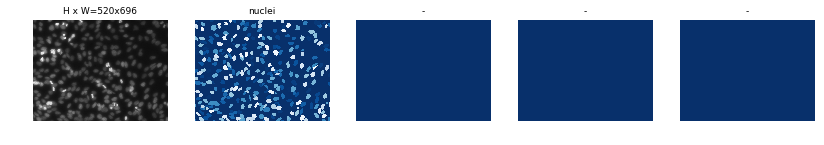

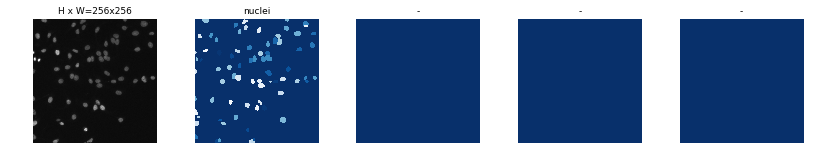

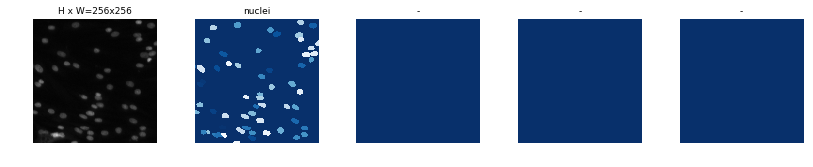

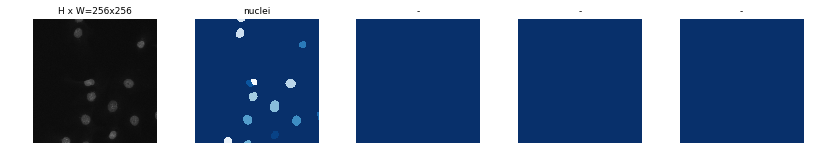

In [60]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)


##Create model

In [80]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [64]:
# Which weights to start with? Used coco weights? 
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

In [65]:
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /Users/yzu280/Documents/kaggle/Kaggle2018/logs/nuclei20180322T0013/mask_rcnn_nuclei_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDis

/Users/yzu280/Documents/kaggle/Kaggle2018/venv/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/Users/yzu280/Documents/kaggle/Kaggle2018/venv/lib/python3.6/site-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1


/Users/yzu280/Documents/kaggle/Kaggle2018/venv/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


/Users/yzu280/Documents/kaggle/Kaggle2018/venv/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


  1/100 [..............................] - ETA: 55:24 - loss: 7.6609 - rpn_class_loss: 0.9995 - rpn_bbox_loss: 2.2630 - mrcnn_class_loss: 2.4073 - mrcnn_bbox_loss: 1.2392 - mrcnn_mask_loss: 0.7519

ERROR:root:Error processing image {'id': 97, 'source': 'nuclei', 'path': './input/stage1_train/a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288/images/a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288.png', 'maskpath': './input/stage1_train/a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288/masks/'}
Traceback (most recent call last):
  File "/Users/yzu280/Documents/kaggle/Kaggle2018/model.py", line 1632, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/Users/yzu280/Documents/kaggle/Kaggle2018/model.py", line 1220, in load_image_gt
    mask = utils.minimize_mask(bbox, mask, config.MINI_MASK_SHAPE)
  File "/Users/yzu280/Documents/kaggle/Kaggle2018/utils.py", line 462, in minimize_mask
    raise Exception("Invalid bounding box with area of zero")
Exception: Invalid bounding box with area of zero

  2/100 [..............................] - ETA: 47:24 - loss: 7.8528 - rpn_class_loss: 1.1498 - rpn_bbox_loss: 2.5657 - mrcnn_class_loss: 2.0253 - mrcnn_bbox_loss: 1.3776 - mrcnn_mask_loss: 0.7343

  3/100 [..............................] - ETA: 43:38 - loss: 7.8602 - rpn_class_loss: 1.4320 - rpn_bbox_loss: 2.7786 - mrcnn_class_loss: 1.5227 - mrcnn_bbox_loss: 1.4105 - mrcnn_mask_loss: 0.7164

  4/100 [>.............................] - ETA: 41:21 - loss: 6.9585 - rpn_class_loss: 1.1181 - rpn_bbox_loss: 2.5240 - mrcnn_class_loss: 1.1755 - mrcnn_bbox_loss: 1.4308 - mrcnn_mask_loss: 0.7101

  5/100 [>.............................] - ETA: 39:00 - loss: 6.4731 - rpn_class_loss: 1.0881 - rpn_bbox_loss: 2.3526 - mrcnn_class_loss: 1.0065 - mrcnn_bbox_loss: 1.3230 - mrcnn_mask_loss: 0.7029

  6/100 [>.............................] - ETA: 37:20 - loss: 5.8821 - rpn_class_loss: 0.9716 - rpn_bbox_loss: 2.1595 - mrcnn_class_loss: 0.8440 - mrcnn_bbox_loss: 1.2069 - mrcnn_mask_loss: 0.7000

  7/100 [=>............................] - ETA: 35:30 - loss: 5.7538 - rpn_class_loss: 0.9190 - rpn_bbox_loss: 2.1761 - mrcnn_class_loss: 0.7712 - mrcnn_bbox_loss: 1.1753 - mrcnn_mask_loss: 0.7121

  8/100 [=>............................] - ETA: 33:58 - loss: 5.8200 - rpn_class_loss: 1.1781 - rpn_bbox_loss: 2.0926 - mrcnn_class_loss: 0.6945 - mrcnn_bbox_loss: 1.1496 - mrcnn_mask_loss: 0.7053

  9/100 [=>............................] - ETA: 32:48 - loss: 5.5413 - rpn_class_loss: 1.0968 - rpn_bbox_loss: 2.0106 - mrcnn_class_loss: 0.6321 - mrcnn_bbox_loss: 1.1109 - mrcnn_mask_loss: 0.6910

 10/100 [==>...........................] - ETA: 31:40 - loss: 5.2852 - rpn_class_loss: 0.9911 - rpn_bbox_loss: 1.9326 - mrcnn_class_loss: 0.5864 - mrcnn_bbox_loss: 1.0883 - mrcnn_mask_loss: 0.6868

 11/100 [==>...........................] - ETA: 30:43 - loss: 5.0380 - rpn_class_loss: 0.9317 - rpn_bbox_loss: 1.8303 - mrcnn_class_loss: 0.5560 - mrcnn_bbox_loss: 1.0425 - mrcnn_mask_loss: 0.6775

 12/100 [==>...........................] - ETA: 29:54 - loss: 4.9733 - rpn_class_loss: 0.9225 - rpn_bbox_loss: 1.7862 - mrcnn_class_loss: 0.5725 - mrcnn_bbox_loss: 1.0231 - mrcnn_mask_loss: 0.6690

 13/100 [==>...........................] - ETA: 29:11 - loss: 4.8763 - rpn_class_loss: 0.8686 - rpn_bbox_loss: 1.7959 - mrcnn_class_loss: 0.5501 - mrcnn_bbox_loss: 1.0069 - mrcnn_mask_loss: 0.6548

 14/100 [===>..........................] - ETA: 28:36 - loss: 4.7863 - rpn_class_loss: 0.8440 - rpn_bbox_loss: 1.7524 - mrcnn_class_loss: 0.5534 - mrcnn_bbox_loss: 0.9897 - mrcnn_mask_loss: 0.6468

 15/100 [===>..........................] - ETA: 28:02 - loss: 4.6551 - rpn_class_loss: 0.8077 - rpn_bbox_loss: 1.7027 - mrcnn_class_loss: 0.5297 - mrcnn_bbox_loss: 0.9769 - mrcnn_mask_loss: 0.6380

 16/100 [===>..........................] - ETA: 27:24 - loss: 4.7119 - rpn_class_loss: 0.8636 - rpn_bbox_loss: 1.7026 - mrcnn_class_loss: 0.5309 - mrcnn_bbox_loss: 0.9798 - mrcnn_mask_loss: 0.6350

 17/100 [====>.........................] - ETA: 26:49 - loss: 4.6562 - rpn_class_loss: 0.8631 - rpn_bbox_loss: 1.6601 - mrcnn_class_loss: 0.5365 - mrcnn_bbox_loss: 0.9654 - mrcnn_mask_loss: 0.6312

 18/100 [====>.........................] - ETA: 26:17 - loss: 4.5519 - rpn_class_loss: 0.8409 - rpn_bbox_loss: 1.6292 - mrcnn_class_loss: 0.5139 - mrcnn_bbox_loss: 0.9395 - mrcnn_mask_loss: 0.6283

 19/100 [====>.........................] - ETA: 25:47 - loss: 4.6090 - rpn_class_loss: 0.8515 - rpn_bbox_loss: 1.6939 - mrcnn_class_loss: 0.4919 - mrcnn_bbox_loss: 0.9369 - mrcnn_mask_loss: 0.6349

 20/100 [=====>........................] - ETA: 25:18 - loss: 4.5964 - rpn_class_loss: 0.8778 - rpn_bbox_loss: 1.6666 - mrcnn_class_loss: 0.4931 - mrcnn_bbox_loss: 0.9239 - mrcnn_mask_loss: 0.6349

 21/100 [=====>........................] - ETA: 24:51 - loss: 4.5027 - rpn_class_loss: 0.8585 - rpn_bbox_loss: 1.6293 - mrcnn_class_loss: 0.4815 - mrcnn_bbox_loss: 0.9039 - mrcnn_mask_loss: 0.6294

 22/100 [=====>........................] - ETA: 24:25 - loss: 4.4231 - rpn_class_loss: 0.8363 - rpn_bbox_loss: 1.5938 - mrcnn_class_loss: 0.4794 - mrcnn_bbox_loss: 0.8879 - mrcnn_mask_loss: 0.6257

 23/100 [=====>........................] - ETA: 23:59 - loss: 4.3554 - rpn_class_loss: 0.8266 - rpn_bbox_loss: 1.5805 - mrcnn_class_loss: 0.4637 - mrcnn_bbox_loss: 0.8678 - mrcnn_mask_loss: 0.6167

 24/100 [======>.......................] - ETA: 23:35 - loss: 4.2824 - rpn_class_loss: 0.8077 - rpn_bbox_loss: 1.5484 - mrcnn_class_loss: 0.4529 - mrcnn_bbox_loss: 0.8587 - mrcnn_mask_loss: 0.6145

 25/100 [======>.......................] - ETA: 23:12 - loss: 4.2774 - rpn_class_loss: 0.8145 - rpn_bbox_loss: 1.5367 - mrcnn_class_loss: 0.4565 - mrcnn_bbox_loss: 0.8544 - mrcnn_mask_loss: 0.6153

 26/100 [======>.......................] - ETA: 22:48 - loss: 4.2165 - rpn_class_loss: 0.7990 - rpn_bbox_loss: 1.5228 - mrcnn_class_loss: 0.4466 - mrcnn_bbox_loss: 0.8397 - mrcnn_mask_loss: 0.6083

 27/100 [=======>......................] - ETA: 22:24 - loss: 4.1628 - rpn_class_loss: 0.7847 - rpn_bbox_loss: 1.4974 - mrcnn_class_loss: 0.4391 - mrcnn_bbox_loss: 0.8389 - mrcnn_mask_loss: 0.6027

 28/100 [=======>......................] - ETA: 22:04 - loss: 4.0964 - rpn_class_loss: 0.7693 - rpn_bbox_loss: 1.4725 - mrcnn_class_loss: 0.4249 - mrcnn_bbox_loss: 0.8315 - mrcnn_mask_loss: 0.5982

 29/100 [=======>......................] - ETA: 21:42 - loss: 4.0274 - rpn_class_loss: 0.7498 - rpn_bbox_loss: 1.4464 - mrcnn_class_loss: 0.4151 - mrcnn_bbox_loss: 0.8207 - mrcnn_mask_loss: 0.5955

 30/100 [========>.....................] - ETA: 21:19 - loss: 3.9629 - rpn_class_loss: 0.7328 - rpn_bbox_loss: 1.4235 - mrcnn_class_loss: 0.4085 - mrcnn_bbox_loss: 0.8079 - mrcnn_mask_loss: 0.5902

 31/100 [========>.....................] - ETA: 20:58 - loss: 3.9274 - rpn_class_loss: 0.7152 - rpn_bbox_loss: 1.4068 - mrcnn_class_loss: 0.4166 - mrcnn_bbox_loss: 0.8019 - mrcnn_mask_loss: 0.5870

 32/100 [========>.....................] - ETA: 20:36 - loss: 3.8580 - rpn_class_loss: 0.6968 - rpn_bbox_loss: 1.3810 - mrcnn_class_loss: 0.4053 - mrcnn_bbox_loss: 0.7939 - mrcnn_mask_loss: 0.5811

 33/100 [========>.....................] - ETA: 20:16 - loss: 3.8295 - rpn_class_loss: 0.6852 - rpn_bbox_loss: 1.3712 - mrcnn_class_loss: 0.3988 - mrcnn_bbox_loss: 0.7925 - mrcnn_mask_loss: 0.5818

 34/100 [=========>....................] - ETA: 19:55 - loss: 3.8075 - rpn_class_loss: 0.6840 - rpn_bbox_loss: 1.3572 - mrcnn_class_loss: 0.3990 - mrcnn_bbox_loss: 0.7867 - mrcnn_mask_loss: 0.5807

 35/100 [=========>....................] - ETA: 19:35 - loss: 3.7838 - rpn_class_loss: 0.6693 - rpn_bbox_loss: 1.3520 - mrcnn_class_loss: 0.3893 - mrcnn_bbox_loss: 0.7927 - mrcnn_mask_loss: 0.5804

 36/100 [=========>....................] - ETA: 19:15 - loss: 3.8468 - rpn_class_loss: 0.6854 - rpn_bbox_loss: 1.3940 - mrcnn_class_loss: 0.3792 - mrcnn_bbox_loss: 0.8025 - mrcnn_mask_loss: 0.5857

 37/100 [==========>...................] - ETA: 18:54 - loss: 3.7927 - rpn_class_loss: 0.6703 - rpn_bbox_loss: 1.3761 - mrcnn_class_loss: 0.3743 - mrcnn_bbox_loss: 0.7909 - mrcnn_mask_loss: 0.5812

 38/100 [==========>...................] - ETA: 18:34 - loss: 3.7707 - rpn_class_loss: 0.6660 - rpn_bbox_loss: 1.3638 - mrcnn_class_loss: 0.3784 - mrcnn_bbox_loss: 0.7835 - mrcnn_mask_loss: 0.5790

 39/100 [==========>...................] - ETA: 18:16 - loss: 3.7190 - rpn_class_loss: 0.6513 - rpn_bbox_loss: 1.3482 - mrcnn_class_loss: 0.3703 - mrcnn_bbox_loss: 0.7736 - mrcnn_mask_loss: 0.5757

 40/100 [===========>..................] - ETA: 17:57 - loss: 3.6808 - rpn_class_loss: 0.6416 - rpn_bbox_loss: 1.3344 - mrcnn_class_loss: 0.3663 - mrcnn_bbox_loss: 0.7659 - mrcnn_mask_loss: 0.5727

 41/100 [===========>..................] - ETA: 17:38 - loss: 3.6523 - rpn_class_loss: 0.6336 - rpn_bbox_loss: 1.3193 - mrcnn_class_loss: 0.3631 - mrcnn_bbox_loss: 0.7638 - mrcnn_mask_loss: 0.5724

 42/100 [===========>..................] - ETA: 17:19 - loss: 3.6761 - rpn_class_loss: 0.6354 - rpn_bbox_loss: 1.3420 - mrcnn_class_loss: 0.3575 - mrcnn_bbox_loss: 0.7666 - mrcnn_mask_loss: 0.5746

 43/100 [===========>..................] - ETA: 17:00 - loss: 3.6448 - rpn_class_loss: 0.6276 - rpn_bbox_loss: 1.3300 - mrcnn_class_loss: 0.3554 - mrcnn_bbox_loss: 0.7613 - mrcnn_mask_loss: 0.5706

 44/100 [============>.................] - ETA: 16:40 - loss: 3.6090 - rpn_class_loss: 0.6163 - rpn_bbox_loss: 1.3188 - mrcnn_class_loss: 0.3518 - mrcnn_bbox_loss: 0.7547 - mrcnn_mask_loss: 0.5674

 45/100 [============>.................] - ETA: 16:23 - loss: 3.5798 - rpn_class_loss: 0.6106 - rpn_bbox_loss: 1.3063 - mrcnn_class_loss: 0.3514 - mrcnn_bbox_loss: 0.7476 - mrcnn_mask_loss: 0.5639

 46/100 [============>.................] - ETA: 16:06 - loss: 3.5574 - rpn_class_loss: 0.6078 - rpn_bbox_loss: 1.3009 - mrcnn_class_loss: 0.3471 - mrcnn_bbox_loss: 0.7415 - mrcnn_mask_loss: 0.5600

 47/100 [=============>................] - ETA: 15:50 - loss: 3.5202 - rpn_class_loss: 0.5996 - rpn_bbox_loss: 1.2852 - mrcnn_class_loss: 0.3453 - mrcnn_bbox_loss: 0.7350 - mrcnn_mask_loss: 0.5552

 48/100 [=============>................] - ETA: 15:31 - loss: 3.5051 - rpn_class_loss: 0.6001 - rpn_bbox_loss: 1.2754 - mrcnn_class_loss: 0.3472 - mrcnn_bbox_loss: 0.7283 - mrcnn_mask_loss: 0.5541

 49/100 [=============>................] - ETA: 15:12 - loss: 3.4779 - rpn_class_loss: 0.5940 - rpn_bbox_loss: 1.2718 - mrcnn_class_loss: 0.3423 - mrcnn_bbox_loss: 0.7196 - mrcnn_mask_loss: 0.5501

 50/100 [==============>...............] - ETA: 14:54 - loss: 3.4508 - rpn_class_loss: 0.5867 - rpn_bbox_loss: 1.2623 - mrcnn_class_loss: 0.3409 - mrcnn_bbox_loss: 0.7141 - mrcnn_mask_loss: 0.5469

 51/100 [==============>...............] - ETA: 14:35 - loss: 3.4480 - rpn_class_loss: 0.5938 - rpn_bbox_loss: 1.2548 - mrcnn_class_loss: 0.3412 - mrcnn_bbox_loss: 0.7125 - mrcnn_mask_loss: 0.5456

 52/100 [==============>...............] - ETA: 14:17 - loss: 3.4294 - rpn_class_loss: 0.5876 - rpn_bbox_loss: 1.2488 - mrcnn_class_loss: 0.3379 - mrcnn_bbox_loss: 0.7114 - mrcnn_mask_loss: 0.5436

 53/100 [==============>...............] - ETA: 13:58 - loss: 3.4039 - rpn_class_loss: 0.5813 - rpn_bbox_loss: 1.2381 - mrcnn_class_loss: 0.3386 - mrcnn_bbox_loss: 0.7057 - mrcnn_mask_loss: 0.5401

 54/100 [===============>..............] - ETA: 13:40 - loss: 3.3671 - rpn_class_loss: 0.5734 - rpn_bbox_loss: 1.2280 - mrcnn_class_loss: 0.3338 - mrcnn_bbox_loss: 0.6975 - mrcnn_mask_loss: 0.5344

 55/100 [===============>..............] - ETA: 13:22 - loss: 3.4155 - rpn_class_loss: 0.6108 - rpn_bbox_loss: 1.2675 - mrcnn_class_loss: 0.3277 - mrcnn_bbox_loss: 0.6848 - mrcnn_mask_loss: 0.5247

 56/100 [===============>..............] - ETA: 13:04 - loss: 3.3949 - rpn_class_loss: 0.6032 - rpn_bbox_loss: 1.2592 - mrcnn_class_loss: 0.3235 - mrcnn_bbox_loss: 0.6818 - mrcnn_mask_loss: 0.5271

 57/100 [================>.............] - ETA: 12:46 - loss: 3.3808 - rpn_class_loss: 0.6003 - rpn_bbox_loss: 1.2507 - mrcnn_class_loss: 0.3252 - mrcnn_bbox_loss: 0.6781 - mrcnn_mask_loss: 0.5265

 58/100 [================>.............] - ETA: 12:28 - loss: 3.3644 - rpn_class_loss: 0.5967 - rpn_bbox_loss: 1.2402 - mrcnn_class_loss: 0.3260 - mrcnn_bbox_loss: 0.6760 - mrcnn_mask_loss: 0.5254

 59/100 [================>.............] - ETA: 12:09 - loss: 3.3396 - rpn_class_loss: 0.5906 - rpn_bbox_loss: 1.2297 - mrcnn_class_loss: 0.3233 - mrcnn_bbox_loss: 0.6715 - mrcnn_mask_loss: 0.5245

 60/100 [=================>............] - ETA: 11:50 - loss: 3.3196 - rpn_class_loss: 0.5855 - rpn_bbox_loss: 1.2220 - mrcnn_class_loss: 0.3218 - mrcnn_bbox_loss: 0.6674 - mrcnn_mask_loss: 0.5228

 61/100 [=================>............] - ETA: 11:32 - loss: 3.3033 - rpn_class_loss: 0.5813 - rpn_bbox_loss: 1.2199 - mrcnn_class_loss: 0.3195 - mrcnn_bbox_loss: 0.6629 - mrcnn_mask_loss: 0.5196

 62/100 [=================>............] - ETA: 11:13 - loss: 3.2815 - rpn_class_loss: 0.5747 - rpn_bbox_loss: 1.2135 - mrcnn_class_loss: 0.3178 - mrcnn_bbox_loss: 0.6585 - mrcnn_mask_loss: 0.5169

 63/100 [=================>............] - ETA: 10:55 - loss: 3.2580 - rpn_class_loss: 0.5679 - rpn_bbox_loss: 1.2059 - mrcnn_class_loss: 0.3155 - mrcnn_bbox_loss: 0.6549 - mrcnn_mask_loss: 0.5137

 64/100 [==================>...........] - ETA: 10:37 - loss: 3.2432 - rpn_class_loss: 0.5630 - rpn_bbox_loss: 1.2049 - mrcnn_class_loss: 0.3132 - mrcnn_bbox_loss: 0.6505 - mrcnn_mask_loss: 0.5116

 65/100 [==================>...........] - ETA: 10:19 - loss: 3.2231 - rpn_class_loss: 0.5581 - rpn_bbox_loss: 1.1973 - mrcnn_class_loss: 0.3133 - mrcnn_bbox_loss: 0.6455 - mrcnn_mask_loss: 0.5089

 66/100 [==================>...........] - ETA: 10:01 - loss: 3.2328 - rpn_class_loss: 0.5703 - rpn_bbox_loss: 1.1927 - mrcnn_class_loss: 0.3137 - mrcnn_bbox_loss: 0.6461 - mrcnn_mask_loss: 0.5099

 67/100 [===================>..........] - ETA: 9:43 - loss: 3.2114 - rpn_class_loss: 0.5647 - rpn_bbox_loss: 1.1880 - mrcnn_class_loss: 0.3106 - mrcnn_bbox_loss: 0.6420 - mrcnn_mask_loss: 0.5062 

 68/100 [===================>..........] - ETA: 9:25 - loss: 3.2315 - rpn_class_loss: 0.5647 - rpn_bbox_loss: 1.2032 - mrcnn_class_loss: 0.3073 - mrcnn_bbox_loss: 0.6451 - mrcnn_mask_loss: 0.5111

 69/100 [===================>..........] - ETA: 9:07 - loss: 3.2064 - rpn_class_loss: 0.5582 - rpn_bbox_loss: 1.1955 - mrcnn_class_loss: 0.3042 - mrcnn_bbox_loss: 0.6407 - mrcnn_mask_loss: 0.5077

 70/100 [====================>.........] - ETA: 8:49 - loss: 3.1926 - rpn_class_loss: 0.5554 - rpn_bbox_loss: 1.1883 - mrcnn_class_loss: 0.3050 - mrcnn_bbox_loss: 0.6380 - mrcnn_mask_loss: 0.5059

 71/100 [====================>.........] - ETA: 8:31 - loss: 3.1704 - rpn_class_loss: 0.5505 - rpn_bbox_loss: 1.1828 - mrcnn_class_loss: 0.3021 - mrcnn_bbox_loss: 0.6323 - mrcnn_mask_loss: 0.5026

 72/100 [====================>.........] - ETA: 8:13 - loss: 3.1631 - rpn_class_loss: 0.5470 - rpn_bbox_loss: 1.1785 - mrcnn_class_loss: 0.3034 - mrcnn_bbox_loss: 0.6317 - mrcnn_mask_loss: 0.5024

 73/100 [====================>.........] - ETA: 7:55 - loss: 3.1535 - rpn_class_loss: 0.5399 - rpn_bbox_loss: 1.1725 - mrcnn_class_loss: 0.2996 - mrcnn_bbox_loss: 0.6361 - mrcnn_mask_loss: 0.5053

 74/100 [=====================>........] - ETA: 7:38 - loss: 3.1277 - rpn_class_loss: 0.5337 - rpn_bbox_loss: 1.1651 - mrcnn_class_loss: 0.2956 - mrcnn_bbox_loss: 0.6314 - mrcnn_mask_loss: 0.5018

 75/100 [=====================>........] - ETA: 7:20 - loss: 3.1101 - rpn_class_loss: 0.5272 - rpn_bbox_loss: 1.1588 - mrcnn_class_loss: 0.2919 - mrcnn_bbox_loss: 0.6301 - mrcnn_mask_loss: 0.5020

 76/100 [=====================>........] - ETA: 7:02 - loss: 3.1005 - rpn_class_loss: 0.5243 - rpn_bbox_loss: 1.1536 - mrcnn_class_loss: 0.2950 - mrcnn_bbox_loss: 0.6269 - mrcnn_mask_loss: 0.5006

 77/100 [======================>.......] - ETA: 6:44 - loss: 3.0775 - rpn_class_loss: 0.5195 - rpn_bbox_loss: 1.1463 - mrcnn_class_loss: 0.2920 - mrcnn_bbox_loss: 0.6218 - mrcnn_mask_loss: 0.4979

 78/100 [======================>.......] - ETA: 6:27 - loss: 3.0563 - rpn_class_loss: 0.5142 - rpn_bbox_loss: 1.1422 - mrcnn_class_loss: 0.2887 - mrcnn_bbox_loss: 0.6172 - mrcnn_mask_loss: 0.4939

 79/100 [======================>.......] - ETA: 6:09 - loss: 3.0332 - rpn_class_loss: 0.5085 - rpn_bbox_loss: 1.1377 - mrcnn_class_loss: 0.2851 - mrcnn_bbox_loss: 0.6113 - mrcnn_mask_loss: 0.4907

 80/100 [=======================>......] - ETA: 5:51 - loss: 3.0374 - rpn_class_loss: 0.5136 - rpn_bbox_loss: 1.1345 - mrcnn_class_loss: 0.2876 - mrcnn_bbox_loss: 0.6106 - mrcnn_mask_loss: 0.4910

 81/100 [=======================>......] - ETA: 5:33 - loss: 3.0223 - rpn_class_loss: 0.5099 - rpn_bbox_loss: 1.1305 - mrcnn_class_loss: 0.2862 - mrcnn_bbox_loss: 0.6070 - mrcnn_mask_loss: 0.4886

 82/100 [=======================>......] - ETA: 5:16 - loss: 3.0104 - rpn_class_loss: 0.5045 - rpn_bbox_loss: 1.1264 - mrcnn_class_loss: 0.2831 - mrcnn_bbox_loss: 0.6076 - mrcnn_mask_loss: 0.4889

 83/100 [=======================>......] - ETA: 4:58 - loss: 2.9929 - rpn_class_loss: 0.5006 - rpn_bbox_loss: 1.1229 - mrcnn_class_loss: 0.2805 - mrcnn_bbox_loss: 0.6029 - mrcnn_mask_loss: 0.4859

 84/100 [========================>.....] - ETA: 4:40 - loss: 2.9778 - rpn_class_loss: 0.4974 - rpn_bbox_loss: 1.1200 - mrcnn_class_loss: 0.2781 - mrcnn_bbox_loss: 0.5992 - mrcnn_mask_loss: 0.4831

 85/100 [========================>.....] - ETA: 4:23 - loss: 2.9643 - rpn_class_loss: 0.4936 - rpn_bbox_loss: 1.1169 - mrcnn_class_loss: 0.2760 - mrcnn_bbox_loss: 0.5970 - mrcnn_mask_loss: 0.4808

 86/100 [========================>.....] - ETA: 4:05 - loss: 2.9547 - rpn_class_loss: 0.4927 - rpn_bbox_loss: 1.1126 - mrcnn_class_loss: 0.2755 - mrcnn_bbox_loss: 0.5943 - mrcnn_mask_loss: 0.4796

 87/100 [=========================>....] - ETA: 3:48 - loss: 2.9469 - rpn_class_loss: 0.4921 - rpn_bbox_loss: 1.1085 - mrcnn_class_loss: 0.2761 - mrcnn_bbox_loss: 0.5917 - mrcnn_mask_loss: 0.4784

 88/100 [=========================>....] - ETA: 3:30 - loss: 2.9385 - rpn_class_loss: 0.4911 - rpn_bbox_loss: 1.1040 - mrcnn_class_loss: 0.2765 - mrcnn_bbox_loss: 0.5896 - mrcnn_mask_loss: 0.4773

 89/100 [=========================>....] - ETA: 3:12 - loss: 2.9275 - rpn_class_loss: 0.4876 - rpn_bbox_loss: 1.1014 - mrcnn_class_loss: 0.2760 - mrcnn_bbox_loss: 0.5870 - mrcnn_mask_loss: 0.4756

 90/100 [==========================>...] - ETA: 2:55 - loss: 2.9220 - rpn_class_loss: 0.4873 - rpn_bbox_loss: 1.0973 - mrcnn_class_loss: 0.2774 - mrcnn_bbox_loss: 0.5852 - mrcnn_mask_loss: 0.4748

 91/100 [==========================>...] - ETA: 2:37 - loss: 2.9112 - rpn_class_loss: 0.4838 - rpn_bbox_loss: 1.0979 - mrcnn_class_loss: 0.2756 - mrcnn_bbox_loss: 0.5813 - mrcnn_mask_loss: 0.4726

 92/100 [==========================>...] - ETA: 2:20 - loss: 2.9018 - rpn_class_loss: 0.4811 - rpn_bbox_loss: 1.0939 - mrcnn_class_loss: 0.2753 - mrcnn_bbox_loss: 0.5785 - mrcnn_mask_loss: 0.4730

 93/100 [==========================>...] - ETA: 2:02 - loss: 2.8966 - rpn_class_loss: 0.4798 - rpn_bbox_loss: 1.0912 - mrcnn_class_loss: 0.2756 - mrcnn_bbox_loss: 0.5780 - mrcnn_mask_loss: 0.4719

 94/100 [===========================>..] - ETA: 1:45 - loss: 2.8919 - rpn_class_loss: 0.4778 - rpn_bbox_loss: 1.0893 - mrcnn_class_loss: 0.2760 - mrcnn_bbox_loss: 0.5778 - mrcnn_mask_loss: 0.4710

 95/100 [===========================>..] - ETA: 1:27 - loss: 2.8723 - rpn_class_loss: 0.4735 - rpn_bbox_loss: 1.0829 - mrcnn_class_loss: 0.2732 - mrcnn_bbox_loss: 0.5741 - mrcnn_mask_loss: 0.4686

 96/100 [===========================>..] - ETA: 1:10 - loss: 2.8767 - rpn_class_loss: 0.4776 - rpn_bbox_loss: 1.0814 - mrcnn_class_loss: 0.2752 - mrcnn_bbox_loss: 0.5741 - mrcnn_mask_loss: 0.4683

 97/100 [============================>.] - ETA: 52s - loss: 2.8659 - rpn_class_loss: 0.4746 - rpn_bbox_loss: 1.0796 - mrcnn_class_loss: 0.2738 - mrcnn_bbox_loss: 0.5715 - mrcnn_mask_loss: 0.4664 

 98/100 [============================>.] - ETA: 34s - loss: 2.8569 - rpn_class_loss: 0.4722 - rpn_bbox_loss: 1.0766 - mrcnn_class_loss: 0.2720 - mrcnn_bbox_loss: 0.5704 - mrcnn_mask_loss: 0.4657

 99/100 [============================>.] - ETA: 17s - loss: 2.8445 - rpn_class_loss: 0.4688 - rpn_bbox_loss: 1.0735 - mrcnn_class_loss: 0.2697 - mrcnn_bbox_loss: 0.5685 - mrcnn_mask_loss: 0.4639

100/100 [==============================] - 1754s 18s/step - loss: 2.8385 - rpn_class_loss: 0.4665 - rpn_bbox_loss: 1.0752 - mrcnn_class_loss: 0.2679 - mrcnn_bbox_loss: 0.5667 - mrcnn_mask_loss: 0.4621 - val_loss: 2.1450 - val_rpn_class_loss: 0.1009 - val_rpn_bbox_loss: 0.6840 - val_mrcnn_class_loss: 0.1095 - val_mrcnn_bbox_loss: 0.7330 - val_mrcnn_mask_loss: 0.5176


##Training
Train in two stages:

Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass layers='heads' to the train() function.

Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass layers="all to train all layers.

In [66]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")


Starting at epoch 1. LR=0.0001

Checkpoint Path: /Users/yzu280/Documents/kaggle/Kaggle2018/logs/nuclei20180322T0013/mask_rcnn_nuclei_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b       

/Users/yzu280/Documents/kaggle/Kaggle2018/venv/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/Users/yzu280/Documents/kaggle/Kaggle2018/venv/lib/python3.6/site-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 2/2


/Users/yzu280/Documents/kaggle/Kaggle2018/venv/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


/Users/yzu280/Documents/kaggle/Kaggle2018/venv/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


ERROR:root:Error processing image {'id': 55, 'source': 'nuclei', 'path': './input/stage1_train/f29fd9c52e04403cd2c7d43b6fe2479292e53b2f61969d25256d2d2aca7c6a81/images/f29fd9c52e04403cd2c7d43b6fe2479292e53b2f61969d25256d2d2aca7c6a81.png', 'maskpath': './input/stage1_train/f29fd9c52e04403cd2c7d43b6fe2479292e53b2f61969d25256d2d2aca7c6a81/masks/'}
Traceback (most recent call last):
  File "/Users/yzu280/Documents/kaggle/Kaggle2018/model.py", line 1632, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/Users/yzu280/Documents/kaggle/Kaggle2018/model.py", line 1220, in load_image_gt
    mask = utils.minimize_mask(bbox, mask, config.MINI_MASK_SHAPE)
  File "/Users/yzu280/Documents/kaggle/Kaggle2018/utils.py", line 462, in minimize_mask
    raise Exception("Invalid bounding box with area of zero")
Exception: Invalid bounding box with area of zero

  1/100 [..............................] - ETA: 1:08:35 - loss: 1.9567 - rpn_class_loss: 0.1038 - rpn_bbox_loss: 0.6056 - mrcnn_class_loss: 0.1856 - mrcnn_bbox_loss: 0.5986 - mrcnn_mask_loss: 0.4632

  2/100 [..............................] - ETA: 49:01 - loss: 1.6229 - rpn_class_loss: 0.1341 - rpn_bbox_loss: 0.5702 - mrcnn_class_loss: 0.1251 - mrcnn_bbox_loss: 0.4341 - mrcnn_mask_loss: 0.3595  

  3/100 [..............................] - ETA: 42:10 - loss: 1.9310 - rpn_class_loss: 0.2186 - rpn_bbox_loss: 0.6747 - mrcnn_class_loss: 0.2707 - mrcnn_bbox_loss: 0.4130 - mrcnn_mask_loss: 0.3540

  4/100 [>.............................] - ETA: 39:02 - loss: 1.7301 - rpn_class_loss: 0.1857 - rpn_bbox_loss: 0.6430 - mrcnn_class_loss: 0.2081 - mrcnn_bbox_loss: 0.3673 - mrcnn_mask_loss: 0.3260

  5/100 [>.............................] - ETA: 36:57 - loss: 1.7346 - rpn_class_loss: 0.1940 - rpn_bbox_loss: 0.6654 - mrcnn_class_loss: 0.2090 - mrcnn_bbox_loss: 0.3426 - mrcnn_mask_loss: 0.3236

  6/100 [>.............................] - ETA: 35:46 - loss: 1.7649 - rpn_class_loss: 0.1898 - rpn_bbox_loss: 0.7090 - mrcnn_class_loss: 0.1886 - mrcnn_bbox_loss: 0.3549 - mrcnn_mask_loss: 0.3227

  7/100 [=>............................] - ETA: 34:23 - loss: 1.8242 - rpn_class_loss: 0.2128 - rpn_bbox_loss: 0.7078 - mrcnn_class_loss: 0.2107 - mrcnn_bbox_loss: 0.3579 - mrcnn_mask_loss: 0.3350

  8/100 [=>............................] - ETA: 33:10 - loss: 1.9390 - rpn_class_loss: 0.2314 - rpn_bbox_loss: 0.7172 - mrcnn_class_loss: 0.2516 - mrcnn_bbox_loss: 0.3817 - mrcnn_mask_loss: 0.3572

  9/100 [=>............................] - ETA: 32:13 - loss: 1.9602 - rpn_class_loss: 0.2221 - rpn_bbox_loss: 0.7204 - mrcnn_class_loss: 0.2446 - mrcnn_bbox_loss: 0.4030 - mrcnn_mask_loss: 0.3701

 10/100 [==>...........................] - ETA: 31:23 - loss: 1.9884 - rpn_class_loss: 0.2453 - rpn_bbox_loss: 0.7215 - mrcnn_class_loss: 0.2502 - mrcnn_bbox_loss: 0.3993 - mrcnn_mask_loss: 0.3720

 11/100 [==>...........................] - ETA: 30:38 - loss: 1.9987 - rpn_class_loss: 0.2595 - rpn_bbox_loss: 0.7150 - mrcnn_class_loss: 0.2554 - mrcnn_bbox_loss: 0.3946 - mrcnn_mask_loss: 0.3741

 12/100 [==>...........................] - ETA: 30:01 - loss: 1.9382 - rpn_class_loss: 0.2488 - rpn_bbox_loss: 0.7069 - mrcnn_class_loss: 0.2381 - mrcnn_bbox_loss: 0.3782 - mrcnn_mask_loss: 0.3662

 13/100 [==>...........................] - ETA: 29:32 - loss: 1.9273 - rpn_class_loss: 0.2446 - rpn_bbox_loss: 0.7203 - mrcnn_class_loss: 0.2275 - mrcnn_bbox_loss: 0.3733 - mrcnn_mask_loss: 0.3616

 14/100 [===>..........................] - ETA: 28:57 - loss: 1.8839 - rpn_class_loss: 0.2421 - rpn_bbox_loss: 0.7172 - mrcnn_class_loss: 0.2133 - mrcnn_bbox_loss: 0.3624 - mrcnn_mask_loss: 0.3489

 15/100 [===>..........................] - ETA: 28:24 - loss: 2.0476 - rpn_class_loss: 0.2567 - rpn_bbox_loss: 0.8359 - mrcnn_class_loss: 0.2056 - mrcnn_bbox_loss: 0.3783 - mrcnn_mask_loss: 0.3710

 16/100 [===>..........................] - ETA: 27:54 - loss: 2.0819 - rpn_class_loss: 0.2761 - rpn_bbox_loss: 0.8346 - mrcnn_class_loss: 0.2114 - mrcnn_bbox_loss: 0.3868 - mrcnn_mask_loss: 0.3729

 17/100 [====>.........................] - ETA: 27:24 - loss: 2.0505 - rpn_class_loss: 0.2691 - rpn_bbox_loss: 0.8343 - mrcnn_class_loss: 0.2034 - mrcnn_bbox_loss: 0.3811 - mrcnn_mask_loss: 0.3627

 18/100 [====>.........................] - ETA: 26:57 - loss: 2.0358 - rpn_class_loss: 0.2657 - rpn_bbox_loss: 0.8251 - mrcnn_class_loss: 0.2071 - mrcnn_bbox_loss: 0.3786 - mrcnn_mask_loss: 0.3593

 19/100 [====>.........................] - ETA: 26:30 - loss: 1.9903 - rpn_class_loss: 0.2577 - rpn_bbox_loss: 0.8094 - mrcnn_class_loss: 0.1997 - mrcnn_bbox_loss: 0.3702 - mrcnn_mask_loss: 0.3532

 20/100 [=====>........................] - ETA: 26:05 - loss: 2.0115 - rpn_class_loss: 0.2587 - rpn_bbox_loss: 0.8074 - mrcnn_class_loss: 0.2118 - mrcnn_bbox_loss: 0.3736 - mrcnn_mask_loss: 0.3601

 21/100 [=====>........................] - ETA: 25:40 - loss: 2.1141 - rpn_class_loss: 0.3411 - rpn_bbox_loss: 0.8725 - mrcnn_class_loss: 0.2018 - mrcnn_bbox_loss: 0.3558 - mrcnn_mask_loss: 0.3430

 22/100 [=====>........................] - ETA: 25:15 - loss: 2.0930 - rpn_class_loss: 0.3355 - rpn_bbox_loss: 0.8657 - mrcnn_class_loss: 0.1992 - mrcnn_bbox_loss: 0.3538 - mrcnn_mask_loss: 0.3389

 23/100 [=====>........................] - ETA: 24:51 - loss: 2.0919 - rpn_class_loss: 0.3354 - rpn_bbox_loss: 0.8610 - mrcnn_class_loss: 0.2005 - mrcnn_bbox_loss: 0.3540 - mrcnn_mask_loss: 0.3410

 24/100 [======>.......................] - ETA: 24:29 - loss: 2.0456 - rpn_class_loss: 0.3251 - rpn_bbox_loss: 0.8442 - mrcnn_class_loss: 0.1942 - mrcnn_bbox_loss: 0.3453 - mrcnn_mask_loss: 0.3367

 25/100 [======>.......................] - ETA: 24:09 - loss: 2.0265 - rpn_class_loss: 0.3199 - rpn_bbox_loss: 0.8324 - mrcnn_class_loss: 0.1934 - mrcnn_bbox_loss: 0.3423 - mrcnn_mask_loss: 0.3385

 26/100 [======>.......................] - ETA: 23:47 - loss: 2.0002 - rpn_class_loss: 0.3141 - rpn_bbox_loss: 0.8259 - mrcnn_class_loss: 0.1904 - mrcnn_bbox_loss: 0.3359 - mrcnn_mask_loss: 0.3339

 27/100 [=======>......................] - ETA: 23:25 - loss: 2.0042 - rpn_class_loss: 0.3135 - rpn_bbox_loss: 0.8300 - mrcnn_class_loss: 0.1862 - mrcnn_bbox_loss: 0.3363 - mrcnn_mask_loss: 0.3382

 28/100 [=======>......................] - ETA: 23:02 - loss: 1.9853 - rpn_class_loss: 0.3086 - rpn_bbox_loss: 0.8265 - mrcnn_class_loss: 0.1849 - mrcnn_bbox_loss: 0.3307 - mrcnn_mask_loss: 0.3346

 29/100 [=======>......................] - ETA: 22:40 - loss: 2.0052 - rpn_class_loss: 0.3192 - rpn_bbox_loss: 0.8264 - mrcnn_class_loss: 0.1896 - mrcnn_bbox_loss: 0.3323 - mrcnn_mask_loss: 0.3376

 30/100 [========>.....................] - ETA: 22:18 - loss: 1.9908 - rpn_class_loss: 0.3158 - rpn_bbox_loss: 0.8223 - mrcnn_class_loss: 0.1878 - mrcnn_bbox_loss: 0.3308 - mrcnn_mask_loss: 0.3341

 31/100 [========>.....................] - ETA: 21:58 - loss: 1.9808 - rpn_class_loss: 0.3129 - rpn_bbox_loss: 0.8159 - mrcnn_class_loss: 0.1905 - mrcnn_bbox_loss: 0.3296 - mrcnn_mask_loss: 0.3319

 32/100 [========>.....................] - ETA: 21:43 - loss: 1.9764 - rpn_class_loss: 0.3114 - rpn_bbox_loss: 0.8154 - mrcnn_class_loss: 0.1901 - mrcnn_bbox_loss: 0.3282 - mrcnn_mask_loss: 0.3312

 33/100 [========>.....................] - ETA: 21:25 - loss: 1.9581 - rpn_class_loss: 0.3044 - rpn_bbox_loss: 0.8184 - mrcnn_class_loss: 0.1852 - mrcnn_bbox_loss: 0.3217 - mrcnn_mask_loss: 0.3284

 34/100 [=========>....................] - ETA: 21:03 - loss: 1.9555 - rpn_class_loss: 0.3001 - rpn_bbox_loss: 0.8197 - mrcnn_class_loss: 0.1821 - mrcnn_bbox_loss: 0.3253 - mrcnn_mask_loss: 0.3283

 35/100 [=========>....................] - ETA: 20:42 - loss: 1.9606 - rpn_class_loss: 0.2964 - rpn_bbox_loss: 0.8175 - mrcnn_class_loss: 0.1847 - mrcnn_bbox_loss: 0.3296 - mrcnn_mask_loss: 0.3324

 36/100 [=========>....................] - ETA: 20:22 - loss: 1.9462 - rpn_class_loss: 0.2937 - rpn_bbox_loss: 0.8145 - mrcnn_class_loss: 0.1827 - mrcnn_bbox_loss: 0.3261 - mrcnn_mask_loss: 0.3291

 37/100 [==========>...................] - ETA: 20:01 - loss: 1.9437 - rpn_class_loss: 0.2923 - rpn_bbox_loss: 0.8160 - mrcnn_class_loss: 0.1826 - mrcnn_bbox_loss: 0.3259 - mrcnn_mask_loss: 0.3269

 38/100 [==========>...................] - ETA: 19:40 - loss: 1.9598 - rpn_class_loss: 0.2999 - rpn_bbox_loss: 0.8171 - mrcnn_class_loss: 0.1866 - mrcnn_bbox_loss: 0.3270 - mrcnn_mask_loss: 0.3292

 39/100 [==========>...................] - ETA: 19:20 - loss: 1.9602 - rpn_class_loss: 0.2963 - rpn_bbox_loss: 0.8153 - mrcnn_class_loss: 0.1895 - mrcnn_bbox_loss: 0.3278 - mrcnn_mask_loss: 0.3313

 40/100 [===========>..................] - ETA: 18:59 - loss: 1.9656 - rpn_class_loss: 0.2995 - rpn_bbox_loss: 0.8122 - mrcnn_class_loss: 0.1936 - mrcnn_bbox_loss: 0.3286 - mrcnn_mask_loss: 0.3317

 41/100 [===========>..................] - ETA: 18:40 - loss: 2.0014 - rpn_class_loss: 0.3157 - rpn_bbox_loss: 0.8119 - mrcnn_class_loss: 0.2037 - mrcnn_bbox_loss: 0.3339 - mrcnn_mask_loss: 0.3361

 42/100 [===========>..................] - ETA: 18:19 - loss: 2.0069 - rpn_class_loss: 0.3175 - rpn_bbox_loss: 0.8097 - mrcnn_class_loss: 0.2069 - mrcnn_bbox_loss: 0.3352 - mrcnn_mask_loss: 0.3375

 43/100 [===========>..................] - ETA: 18:02 - loss: 2.0177 - rpn_class_loss: 0.3111 - rpn_bbox_loss: 0.8099 - mrcnn_class_loss: 0.2041 - mrcnn_bbox_loss: 0.3462 - mrcnn_mask_loss: 0.3464

 44/100 [============>.................] - ETA: 17:41 - loss: 2.0187 - rpn_class_loss: 0.3136 - rpn_bbox_loss: 0.8084 - mrcnn_class_loss: 0.2045 - mrcnn_bbox_loss: 0.3451 - mrcnn_mask_loss: 0.3471

 45/100 [============>.................] - ETA: 17:22 - loss: 2.0298 - rpn_class_loss: 0.3210 - rpn_bbox_loss: 0.8072 - mrcnn_class_loss: 0.2071 - mrcnn_bbox_loss: 0.3458 - mrcnn_mask_loss: 0.3486

 46/100 [============>.................] - ETA: 17:01 - loss: 2.0168 - rpn_class_loss: 0.3170 - rpn_bbox_loss: 0.8016 - mrcnn_class_loss: 0.2047 - mrcnn_bbox_loss: 0.3453 - mrcnn_mask_loss: 0.3481

 47/100 [=============>................] - ETA: 16:42 - loss: 2.0084 - rpn_class_loss: 0.3144 - rpn_bbox_loss: 0.8011 - mrcnn_class_loss: 0.2030 - mrcnn_bbox_loss: 0.3446 - mrcnn_mask_loss: 0.3454

 48/100 [=============>................] - ETA: 16:22 - loss: 2.0104 - rpn_class_loss: 0.3156 - rpn_bbox_loss: 0.7999 - mrcnn_class_loss: 0.2053 - mrcnn_bbox_loss: 0.3445 - mrcnn_mask_loss: 0.3450

 49/100 [=============>................] - ETA: 16:04 - loss: 2.0259 - rpn_class_loss: 0.3189 - rpn_bbox_loss: 0.8011 - mrcnn_class_loss: 0.2119 - mrcnn_bbox_loss: 0.3465 - mrcnn_mask_loss: 0.3475

 50/100 [==============>...............] - ETA: 15:44 - loss: 2.0209 - rpn_class_loss: 0.3174 - rpn_bbox_loss: 0.8029 - mrcnn_class_loss: 0.2084 - mrcnn_bbox_loss: 0.3460 - mrcnn_mask_loss: 0.3463

 51/100 [==============>...............] - ETA: 15:25 - loss: 2.0127 - rpn_class_loss: 0.3138 - rpn_bbox_loss: 0.8018 - mrcnn_class_loss: 0.2057 - mrcnn_bbox_loss: 0.3451 - mrcnn_mask_loss: 0.3462

 52/100 [==============>...............] - ETA: 15:06 - loss: 2.0027 - rpn_class_loss: 0.3087 - rpn_bbox_loss: 0.8012 - mrcnn_class_loss: 0.2021 - mrcnn_bbox_loss: 0.3448 - mrcnn_mask_loss: 0.3458

 53/100 [==============>...............] - ETA: 14:46 - loss: 2.0475 - rpn_class_loss: 0.3154 - rpn_bbox_loss: 0.8254 - mrcnn_class_loss: 0.2009 - mrcnn_bbox_loss: 0.3549 - mrcnn_mask_loss: 0.3510

 54/100 [===============>..............] - ETA: 14:27 - loss: 2.0457 - rpn_class_loss: 0.3130 - rpn_bbox_loss: 0.8322 - mrcnn_class_loss: 0.1998 - mrcnn_bbox_loss: 0.3524 - mrcnn_mask_loss: 0.3483

ERROR:root:Error processing image {'id': 55, 'source': 'nuclei', 'path': './input/stage1_train/f29fd9c52e04403cd2c7d43b6fe2479292e53b2f61969d25256d2d2aca7c6a81/images/f29fd9c52e04403cd2c7d43b6fe2479292e53b2f61969d25256d2d2aca7c6a81.png', 'maskpath': './input/stage1_train/f29fd9c52e04403cd2c7d43b6fe2479292e53b2f61969d25256d2d2aca7c6a81/masks/'}
Traceback (most recent call last):
  File "/Users/yzu280/Documents/kaggle/Kaggle2018/model.py", line 1632, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/Users/yzu280/Documents/kaggle/Kaggle2018/model.py", line 1220, in load_image_gt
    mask = utils.minimize_mask(bbox, mask, config.MINI_MASK_SHAPE)
  File "/Users/yzu280/Documents/kaggle/Kaggle2018/utils.py", line 462, in minimize_mask
    raise Exception("Invalid bounding box with area of zero")
Exception: Invalid bounding box with area of zero

 55/100 [===============>..............] - ETA: 14:09 - loss: 2.0439 - rpn_class_loss: 0.3101 - rpn_bbox_loss: 0.8311 - mrcnn_class_loss: 0.1979 - mrcnn_bbox_loss: 0.3546 - mrcnn_mask_loss: 0.3500

 56/100 [===============>..............] - ETA: 13:50 - loss: 2.0293 - rpn_class_loss: 0.3062 - rpn_bbox_loss: 0.8269 - mrcnn_class_loss: 0.1950 - mrcnn_bbox_loss: 0.3527 - mrcnn_mask_loss: 0.3485

 57/100 [================>.............] - ETA: 13:30 - loss: 2.0194 - rpn_class_loss: 0.3038 - rpn_bbox_loss: 0.8267 - mrcnn_class_loss: 0.1935 - mrcnn_bbox_loss: 0.3496 - mrcnn_mask_loss: 0.3457

 58/100 [================>.............] - ETA: 13:11 - loss: 2.0101 - rpn_class_loss: 0.3002 - rpn_bbox_loss: 0.8253 - mrcnn_class_loss: 0.1911 - mrcnn_bbox_loss: 0.3477 - mrcnn_mask_loss: 0.3457

 59/100 [================>.............] - ETA: 12:53 - loss: 1.9979 - rpn_class_loss: 0.2978 - rpn_bbox_loss: 0.8220 - mrcnn_class_loss: 0.1885 - mrcnn_bbox_loss: 0.3455 - mrcnn_mask_loss: 0.3441

 60/100 [=================>............] - ETA: 12:33 - loss: 1.9932 - rpn_class_loss: 0.2972 - rpn_bbox_loss: 0.8201 - mrcnn_class_loss: 0.1878 - mrcnn_bbox_loss: 0.3442 - mrcnn_mask_loss: 0.3439

 61/100 [=================>............] - ETA: 12:14 - loss: 1.9964 - rpn_class_loss: 0.2934 - rpn_bbox_loss: 0.8216 - mrcnn_class_loss: 0.1858 - mrcnn_bbox_loss: 0.3492 - mrcnn_mask_loss: 0.3464

 62/100 [=================>............] - ETA: 11:55 - loss: 1.9854 - rpn_class_loss: 0.2904 - rpn_bbox_loss: 0.8208 - mrcnn_class_loss: 0.1830 - mrcnn_bbox_loss: 0.3463 - mrcnn_mask_loss: 0.3449

 63/100 [=================>............] - ETA: 11:36 - loss: 1.9892 - rpn_class_loss: 0.2903 - rpn_bbox_loss: 0.8204 - mrcnn_class_loss: 0.1831 - mrcnn_bbox_loss: 0.3484 - mrcnn_mask_loss: 0.3470

 64/100 [==================>...........] - ETA: 11:17 - loss: 2.0315 - rpn_class_loss: 0.3023 - rpn_bbox_loss: 0.8644 - mrcnn_class_loss: 0.1803 - mrcnn_bbox_loss: 0.3429 - mrcnn_mask_loss: 0.3416

 65/100 [==================>...........] - ETA: 10:58 - loss: 2.0309 - rpn_class_loss: 0.2994 - rpn_bbox_loss: 0.8623 - mrcnn_class_loss: 0.1797 - mrcnn_bbox_loss: 0.3465 - mrcnn_mask_loss: 0.3430

 66/100 [==================>...........] - ETA: 10:39 - loss: 2.0226 - rpn_class_loss: 0.2974 - rpn_bbox_loss: 0.8605 - mrcnn_class_loss: 0.1789 - mrcnn_bbox_loss: 0.3451 - mrcnn_mask_loss: 0.3407

 67/100 [===================>..........] - ETA: 10:20 - loss: 2.0184 - rpn_class_loss: 0.2956 - rpn_bbox_loss: 0.8584 - mrcnn_class_loss: 0.1794 - mrcnn_bbox_loss: 0.3448 - mrcnn_mask_loss: 0.3402

 68/100 [===================>..........] - ETA: 10:01 - loss: 2.0089 - rpn_class_loss: 0.2929 - rpn_bbox_loss: 0.8546 - mrcnn_class_loss: 0.1797 - mrcnn_bbox_loss: 0.3431 - mrcnn_mask_loss: 0.3386

 69/100 [===================>..........] - ETA: 9:42 - loss: 2.0029 - rpn_class_loss: 0.2920 - rpn_bbox_loss: 0.8510 - mrcnn_class_loss: 0.1809 - mrcnn_bbox_loss: 0.3417 - mrcnn_mask_loss: 0.3373 

 70/100 [====================>.........] - ETA: 9:23 - loss: 1.9974 - rpn_class_loss: 0.2910 - rpn_bbox_loss: 0.8497 - mrcnn_class_loss: 0.1807 - mrcnn_bbox_loss: 0.3399 - mrcnn_mask_loss: 0.3361

 71/100 [====================>.........] - ETA: 9:04 - loss: 1.9958 - rpn_class_loss: 0.2904 - rpn_bbox_loss: 0.8462 - mrcnn_class_loss: 0.1831 - mrcnn_bbox_loss: 0.3395 - mrcnn_mask_loss: 0.3365

 72/100 [====================>.........] - ETA: 8:45 - loss: 1.9819 - rpn_class_loss: 0.2876 - rpn_bbox_loss: 0.8413 - mrcnn_class_loss: 0.1811 - mrcnn_bbox_loss: 0.3374 - mrcnn_mask_loss: 0.3345

 73/100 [====================>.........] - ETA: 8:27 - loss: 1.9841 - rpn_class_loss: 0.2859 - rpn_bbox_loss: 0.8444 - mrcnn_class_loss: 0.1801 - mrcnn_bbox_loss: 0.3388 - mrcnn_mask_loss: 0.3348

 74/100 [=====================>........] - ETA: 8:08 - loss: 1.9840 - rpn_class_loss: 0.2837 - rpn_bbox_loss: 0.8440 - mrcnn_class_loss: 0.1798 - mrcnn_bbox_loss: 0.3397 - mrcnn_mask_loss: 0.3368

 75/100 [=====================>........] - ETA: 7:49 - loss: 1.9754 - rpn_class_loss: 0.2827 - rpn_bbox_loss: 0.8425 - mrcnn_class_loss: 0.1784 - mrcnn_bbox_loss: 0.3373 - mrcnn_mask_loss: 0.3344

 76/100 [=====================>........] - ETA: 7:30 - loss: 1.9661 - rpn_class_loss: 0.2810 - rpn_bbox_loss: 0.8417 - mrcnn_class_loss: 0.1767 - mrcnn_bbox_loss: 0.3348 - mrcnn_mask_loss: 0.3320

 77/100 [======================>.......] - ETA: 7:11 - loss: 1.9866 - rpn_class_loss: 0.2927 - rpn_bbox_loss: 0.8418 - mrcnn_class_loss: 0.1812 - mrcnn_bbox_loss: 0.3371 - mrcnn_mask_loss: 0.3339

 78/100 [======================>.......] - ETA: 6:52 - loss: 1.9766 - rpn_class_loss: 0.2908 - rpn_bbox_loss: 0.8380 - mrcnn_class_loss: 0.1797 - mrcnn_bbox_loss: 0.3349 - mrcnn_mask_loss: 0.3332

 79/100 [======================>.......] - ETA: 6:33 - loss: 1.9751 - rpn_class_loss: 0.2887 - rpn_bbox_loss: 0.8376 - mrcnn_class_loss: 0.1788 - mrcnn_bbox_loss: 0.3348 - mrcnn_mask_loss: 0.3352

 80/100 [=======================>......] - ETA: 6:15 - loss: 1.9655 - rpn_class_loss: 0.2864 - rpn_bbox_loss: 0.8362 - mrcnn_class_loss: 0.1776 - mrcnn_bbox_loss: 0.3322 - mrcnn_mask_loss: 0.3330

 81/100 [=======================>......] - ETA: 5:56 - loss: 1.9960 - rpn_class_loss: 0.2885 - rpn_bbox_loss: 0.8536 - mrcnn_class_loss: 0.1761 - mrcnn_bbox_loss: 0.3417 - mrcnn_mask_loss: 0.3361

 82/100 [=======================>......] - ETA: 5:37 - loss: 1.9874 - rpn_class_loss: 0.2860 - rpn_bbox_loss: 0.8494 - mrcnn_class_loss: 0.1746 - mrcnn_bbox_loss: 0.3419 - mrcnn_mask_loss: 0.3355

 83/100 [=======================>......] - ETA: 5:18 - loss: 1.9893 - rpn_class_loss: 0.2842 - rpn_bbox_loss: 0.8476 - mrcnn_class_loss: 0.1767 - mrcnn_bbox_loss: 0.3436 - mrcnn_mask_loss: 0.3372

 84/100 [========================>.....] - ETA: 4:59 - loss: 1.9786 - rpn_class_loss: 0.2816 - rpn_bbox_loss: 0.8450 - mrcnn_class_loss: 0.1748 - mrcnn_bbox_loss: 0.3409 - mrcnn_mask_loss: 0.3362

 85/100 [========================>.....] - ETA: 4:41 - loss: 1.9711 - rpn_class_loss: 0.2793 - rpn_bbox_loss: 0.8439 - mrcnn_class_loss: 0.1736 - mrcnn_bbox_loss: 0.3390 - mrcnn_mask_loss: 0.3353

 86/100 [========================>.....] - ETA: 4:22 - loss: 1.9850 - rpn_class_loss: 0.2864 - rpn_bbox_loss: 0.8424 - mrcnn_class_loss: 0.1772 - mrcnn_bbox_loss: 0.3416 - mrcnn_mask_loss: 0.3374

 87/100 [=========================>....] - ETA: 4:03 - loss: 1.9763 - rpn_class_loss: 0.2837 - rpn_bbox_loss: 0.8414 - mrcnn_class_loss: 0.1752 - mrcnn_bbox_loss: 0.3394 - mrcnn_mask_loss: 0.3365

 88/100 [=========================>....] - ETA: 3:44 - loss: 1.9797 - rpn_class_loss: 0.2854 - rpn_bbox_loss: 0.8398 - mrcnn_class_loss: 0.1773 - mrcnn_bbox_loss: 0.3397 - mrcnn_mask_loss: 0.3374

 89/100 [=========================>....] - ETA: 3:25 - loss: 1.9815 - rpn_class_loss: 0.2850 - rpn_bbox_loss: 0.8394 - mrcnn_class_loss: 0.1793 - mrcnn_bbox_loss: 0.3400 - mrcnn_mask_loss: 0.3378

 90/100 [==========================>...] - ETA: 3:06 - loss: 1.9903 - rpn_class_loss: 0.2901 - rpn_bbox_loss: 0.8394 - mrcnn_class_loss: 0.1814 - mrcnn_bbox_loss: 0.3409 - mrcnn_mask_loss: 0.3386

 91/100 [==========================>...] - ETA: 2:48 - loss: 1.9804 - rpn_class_loss: 0.2879 - rpn_bbox_loss: 0.8371 - mrcnn_class_loss: 0.1799 - mrcnn_bbox_loss: 0.3386 - mrcnn_mask_loss: 0.3369

 92/100 [==========================>...] - ETA: 2:29 - loss: 1.9757 - rpn_class_loss: 0.2862 - rpn_bbox_loss: 0.8364 - mrcnn_class_loss: 0.1795 - mrcnn_bbox_loss: 0.3375 - mrcnn_mask_loss: 0.3361

 93/100 [==========================>...] - ETA: 2:10 - loss: 1.9829 - rpn_class_loss: 0.2902 - rpn_bbox_loss: 0.8354 - mrcnn_class_loss: 0.1822 - mrcnn_bbox_loss: 0.3384 - mrcnn_mask_loss: 0.3367

 94/100 [===========================>..] - ETA: 1:51 - loss: 1.9765 - rpn_class_loss: 0.2886 - rpn_bbox_loss: 0.8350 - mrcnn_class_loss: 0.1812 - mrcnn_bbox_loss: 0.3368 - mrcnn_mask_loss: 0.3350

 95/100 [===========================>..] - ETA: 1:33 - loss: 1.9753 - rpn_class_loss: 0.2878 - rpn_bbox_loss: 0.8367 - mrcnn_class_loss: 0.1802 - mrcnn_bbox_loss: 0.3366 - mrcnn_mask_loss: 0.3339

 96/100 [===========================>..] - ETA: 1:14 - loss: 1.9708 - rpn_class_loss: 0.2862 - rpn_bbox_loss: 0.8368 - mrcnn_class_loss: 0.1793 - mrcnn_bbox_loss: 0.3357 - mrcnn_mask_loss: 0.3327

 97/100 [============================>.] - ETA: 55s - loss: 1.9614 - rpn_class_loss: 0.2843 - rpn_bbox_loss: 0.8333 - mrcnn_class_loss: 0.1783 - mrcnn_bbox_loss: 0.3339 - mrcnn_mask_loss: 0.3317 

 98/100 [============================>.] - ETA: 37s - loss: 1.9544 - rpn_class_loss: 0.2822 - rpn_bbox_loss: 0.8322 - mrcnn_class_loss: 0.1769 - mrcnn_bbox_loss: 0.3320 - mrcnn_mask_loss: 0.3312

 99/100 [============================>.] - ETA: 18s - loss: 1.9517 - rpn_class_loss: 0.2815 - rpn_bbox_loss: 0.8318 - mrcnn_class_loss: 0.1762 - mrcnn_bbox_loss: 0.3314 - mrcnn_mask_loss: 0.3308

100/100 [==============================] - 1869s 19s/step - loss: 1.9528 - rpn_class_loss: 0.2805 - rpn_bbox_loss: 0.8343 - mrcnn_class_loss: 0.1753 - mrcnn_bbox_loss: 0.3322 - mrcnn_mask_loss: 0.3305 - val_loss: 2.7931 - val_rpn_class_loss: 0.6121 - val_rpn_bbox_loss: 0.8568 - val_mrcnn_class_loss: 0.4861 - val_mrcnn_bbox_loss: 0.4260 - val_mrcnn_mask_loss: 0.4121


In [67]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes_0322.h5")
model.keras_model.save_weights(model_path)

##Detection

In [68]:
class InferenceConfig(NucleiConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes_0319.h5")
#model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /Users/yzu280/Documents/kaggle/Kaggle2018/logs/mask_rcnn_shapes_0319.h5


{'id': 22, 'source': 'nuclei', 'path': './input/stage1_train/3582166ee20755856adf4882a8bfacb616fce4247911605a109c4862de421bcd/images/3582166ee20755856adf4882a8bfacb616fce4247911605a109c4862de421bcd.png', 'maskpath': './input/stage1_train/3582166ee20755856adf4882a8bfacb616fce4247911605a109c4862de421bcd/masks/'}
original_image           shape: (256, 256, 3)         min:   11.00000  max:  255.00000
image_meta               shape: (10,)                 min:    0.00000  max:  256.00000
gt_class_id              shape: (44,)                 min:    1.00000  max:    1.00000
gt_bbox                  shape: (44, 4)               min:    0.00000  max:  256.00000
gt_mask                  shape: (256, 256, 44)        min:    0.00000  max:    1.00000


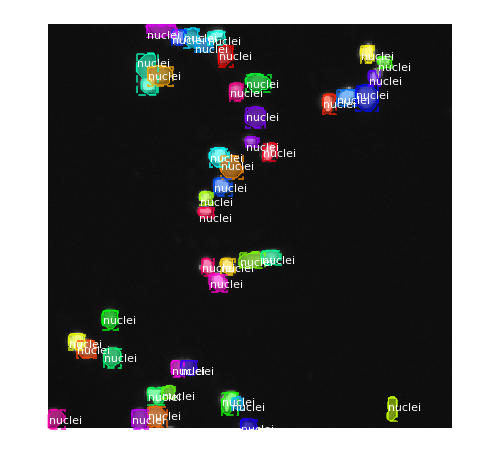

In [69]:
# Test on a random image
image_id = random.choice(dataset_train.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_train, inference_config, 
                           image_id, use_mini_mask=False)
print(dataset_train.image_info[image_id])
log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [70]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

How it works in training dataset

Processing 1 images
image                    shape: (256, 256, 3)         min:   11.00000  max:  255.00000
molded_images            shape: (1, 256, 256, 3)      min: -112.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000


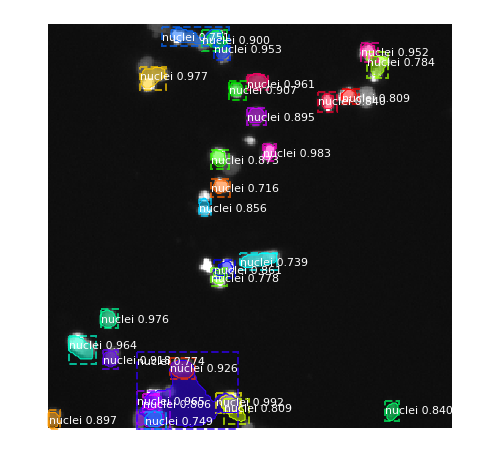

In [71]:
results = model.detect([original_image], verbose=1)

r = results[0]
#print(r)
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

How it works in validation dataset

/Users/yzu280/Documents/kaggle/Kaggle2018/venv/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


{'id': 122, 'source': 'nuclei', 'path': './input/stage1_train/3b0709483b1e86449cc355bb797e841117ba178c6ae1ed955384f4da6486aa20/images/3b0709483b1e86449cc355bb797e841117ba178c6ae1ed955384f4da6486aa20.png', 'maskpath': './input/stage1_train/3b0709483b1e86449cc355bb797e841117ba178c6ae1ed955384f4da6486aa20/masks/'}
original_image           shape: (256, 256, 3)         min:    0.00000  max:  213.00000
image_meta               shape: (10,)                 min:    0.00000  max:  320.00000
gt_class_id              shape: (17,)                 min:    1.00000  max:    1.00000
gt_bbox                  shape: (17, 4)               min:    0.00000  max:  256.00000
gt_mask                  shape: (256, 256, 17)        min:    0.00000  max:    1.00000


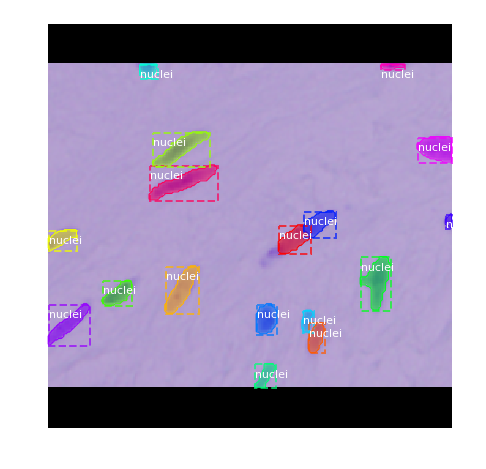

In [72]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)
print(dataset_val.image_info[image_id])
log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  213.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  109.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000


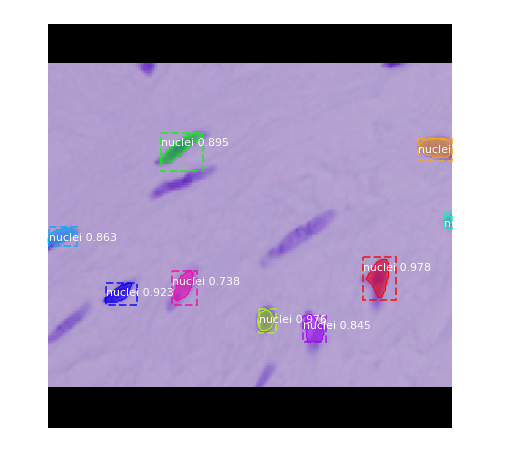

In [73]:
results = model.detect([original_image], verbose=1)

r = results[0]
#print(r)
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [17]:
print()

/Users/yzu280/Documents/kaggle/Kaggle2018/logs/mask_rcnn_shapes_0313.h5
